In [1]:
import seaborn as sns

import sklearn
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics import consensus_score

import torch as T
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import scipy.linalg
from functools import partial
%pylab
%matplotlib inline
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
from __future__ import print_function
import gc
from tqdm import tqdm
from __future__ import division
import pandas as pd
import seaborn as sb
import os
from tqdm import tqdm
from scipy.spatial import distance
from scipy.cluster import hierarchy
from pandas import DataFrame

import os, sys, datetime
LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
sys.path.insert(0,LF_CODE_PATH)
sys.path.insert(0,FT_CODE_PATH)
sys.path.insert(0,FD_CODE_PATH)

import passivity_2p_imaging_utils as p2putils
import visualization_utils as vizutil
reload(p2putils)
tmp_dir = '/tmp/'
all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

f = all_data['e'][2]

# df, sig = f.get_cnmf_roi_table_and_signals()
M = f.get_signals_raw(z=None)

# data = np.load("../cnmf_f01555.npz")
# cnmf = data['cnmf'].astype(np.float32)
# raw = data['raw'].astype(np.float32)
# del data

def moving_average(a, n=3):
    # a is a signal
    ret = np.cumsum(a,0) # sum over time
    ret[n:] = ret[n:] - ret[:-n] # diff of n samples back
    rm = ret[n - 1:] / n
    pad_start = np.full((n-1,rm.shape[1]), rm[0])
    return np.vstack([pad_start, rm])

def ewma(data,span):
    "exponential weighted moving average."
    df = DataFrame(data)
    return df.ewm(span).mean().values

def df_f(x,ma_window=6,span=6):
    u = moving_average(x,ma_window)
    return ewma((x - u)/u, span)

# neurons = sig.T
neurons = M.T

neuron_ids = np.sort(np.argsort(neurons.std(0))[-5000:])
df = f.get_roi_table()
df = df.iloc[neuron_ids]
df.reset_index(drop=True, inplace=True)
neurons = neurons[:,neuron_ids]

neurons = T.from_numpy(df_f(neurons).astype(np.float32)).cuda()
neurons = (neurons - neurons.mean(0))/(neurons.std(0)+1e-8)

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
exclude_before = 1
exclude_after = 4
motion_frames = numpy.searchsorted(f.frame_et[:,-1], f.tail_movement_start_times,side="left")
exclude_idx = np.unique((motion_frames[:,None] + np.arange(-exclude_before,exclude_after+1)[None]).flatten())

In [3]:
X = []
Y = []
for i, (x, y) in enumerate(zip(neurons[:-1,None], neurons[1:,None])):
    if i in set(list(exclude_idx)):
        continue
    else:
        X.append(x)
        Y.append(y)
X = np.vstack(X)
Y = np.vstack(Y)

In [4]:
def corrcoef(x):
    # calculate covariance matrix of rows
    mean_x = torch.mean(x, 1, keepdim=True)
    xm = x.sub(mean_x.expand_as(x))
    c = xm.mm(xm.t())
    c = c / (x.size(1) - 1)

    # normalize covariance matrix
    d = torch.diag(c)
    stddev = torch.pow(d, 0.5)
    c = c.div(stddev.expand_as(c)+1e-8)
    c = c.div(stddev.expand_as(c).t()+1e-8)

    # clamp between -1 and 1
    # probably not necessary but numpy does it
    c = torch.clamp(c, -1.0, 1.0)

    return c

def idx_permute(start, theEnd, exclude_idx):
    num_before_start = np.sum(exclude_idx<start)
    num_before_end = np.sum(exclude_idx<theEnd)
    return start - num_before_start, theEnd - num_before_end

# idx_permute(1,10,np.arange(0,0))

class Granger(nn.Module):
    def __init__(self, nfeatures, n_past_steps, std=0.1, dtype=T.float32,bias=True):
        # we will perform nfeatures x nfeatures regressions
        super(Granger, self).__init__()
        if dtype==T.float32:
            tensor = T.cuda.FloatTensor
        elif dtype==T.float16:
            tensor = T.cuda.HalfTensor
        # Granger coefficient
        self.G = nn.Parameter(tensor(n_past_steps,nfeatures,nfeatures).normal_(std),
                              requires_grad=True)
        self.auto = nn.Parameter(tensor(n_past_steps,nfeatures,nfeatures).normal_(std),
                              requires_grad=True)
        self.bias = bias
        # Bias matrix
        if self.bias:
            self.B = nn.Parameter(tensor(nfeatures, nfeatures).normal_(std),requires_grad=True)

        self.n_past_steps = n_past_steps
        self.tensor = tensor
        self.dtype = dtype

    def forward(self, x_true, n_past_steps=None):
        if n_past_steps==None:
            n_past_steps = self.n_past_steps
        # nfeatures is n neurons & n_past_steps is lag
        # adding dim to make broadcast work
        # x_true is batch x lag x nfeatures x         1
        # G is          1 x lag x nfeatures x nfeatures
        y = self.G[None] * x_true[:,:,:,None]+ self.auto[None] * x_true[:,:,None,:]
        # sum lag so y is batch x nfeatures x nfeatures
        if self.bias:
            return y.sum(1) + self.B[None]
        else:
            return y.sum(1)

def train(model,data,nepochs=1, l1p=1e-8, l2=0, lr=1e-3,batch_size=16, verbose=True):
    # l1 per parameter
    l1 = l1p / np.prod(T.tensor(model.G.shape).numpy())
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    if verbose:
        epochs = range(nepochs)
    else:
        loader = dataloader
        epochs = tqdm(range(nepochs))
    for epoch in epochs:
        if verbose:
            loader = tqdm(dataloader)
        for X,Y in loader:
            Y_pred = model.forward(X)
            l = 0
#             for param in model.parameters():
#                 l += l1* param.norm(1) + l2 *param.norm(2)
            if model.bias:
                l = l1*model.G.norm(1) + l1*model.B.norm(1)
            else:
                l = l1*model.G.norm(1)
            loss = F.mse_loss(Y[:,None,:], Y_pred) + l
            optimizer.zero_grad()
            loss.backward()# back props
            optimizer.step()# update the parameters
        if verbose:
            print('epoch {}, loss {}'.format(epoch,loss.data))

In [5]:
times = []
for t in [0,2000]: #np.arange(1600,2800,200):
    times.append(slice(*idx_permute(t,t+400, exclude_idx)))
times 


[slice(0, 241, None), slice(1592, 1992, None)]

In [6]:
# model = Granger(len(neuron_ids),1,bias=False)
Gs = np.zeros([len(times),X.shape[1],X.shape[1]])

l1 = 5e-6
for it,ind in enumerate(times):
    model = Granger(X.shape[1],1,bias=False)
    data = T.utils.data.TensorDataset(T.from_numpy(X[ind,None]).cuda(),
                                  T.from_numpy(Y[ind]).cuda())
    train(model,data,3,l1p=1e-0,lr=1e-1,batch_size=1,verbose=False)
    train(model,data,15,l1p=5e-2,lr=1e-3,batch_size=1,verbose=False)
    Gs[it] = model.G.data[0].detach().cpu().numpy()

  0%|          | 0/3 [00:00<?, ?it/s]

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1524577523076/work/aten/src/THC/generic/THCStorage.cu:58

In [74]:
id1,id2 = np.indices(Gs.shape[1:])
idx = (np.argmax(np.abs(Gs),axis=0), id1, id2)

In [75]:
Gs[idx]

array([[ 0.050147  , -0.04579193,  0.10733056, ..., -0.04117622,
        -0.04840166, -0.07304259],
       [ 0.00369994, -0.0023567 , -0.14453296, ..., -0.04322043,
        -0.11128376, -0.04189424],
       [-0.0304839 , -0.00798159,  0.03733654, ...,  0.05334378,
        -0.03460224,  0.08631305],
       ...,
       [ 0.05628892,  0.00888034, -0.0908618 , ...,  0.10253134,
         0.05286777, -0.04306531],
       [ 0.04465559,  0.02263026, -0.02127715, ..., -0.04947733,
        -0.05407375, -0.09497139],
       [-0.05426683,  0.02000375, -0.04556135, ...,  0.00591268,
         0.08437878, -0.01929243]])

In [91]:
# G = T.from_numpy(Gs[idx]).cuda()
G = T.from_numpy(Gs).cuda().mean(0)

In [92]:
def cm_cycle(i):
    i = i - 1
    cmap = plt.get_cmap("tab10")
    color = cmap(i%10)
    if i%10==7:
        color = (color[0],color[1],color[2]+0.4)
    return color

In [93]:
row_corr = corrcoef(G).cpu().numpy()

row_linkage = hierarchy.linkage(
    distance.pdist(row_corr), method='ward')

col_corr = corrcoef(model.G[0].t().detach()).cpu().numpy()
col_linkage = hierarchy.linkage(
    distance.pdist(col_corr.T), method='ward')

In [94]:
g_nclust = 20
row_clusters = hierarchy.fcluster(row_linkage,g_nclust,criterion='maxclust')
col_clusters = hierarchy.fcluster(col_linkage,g_nclust,criterion='maxclust')

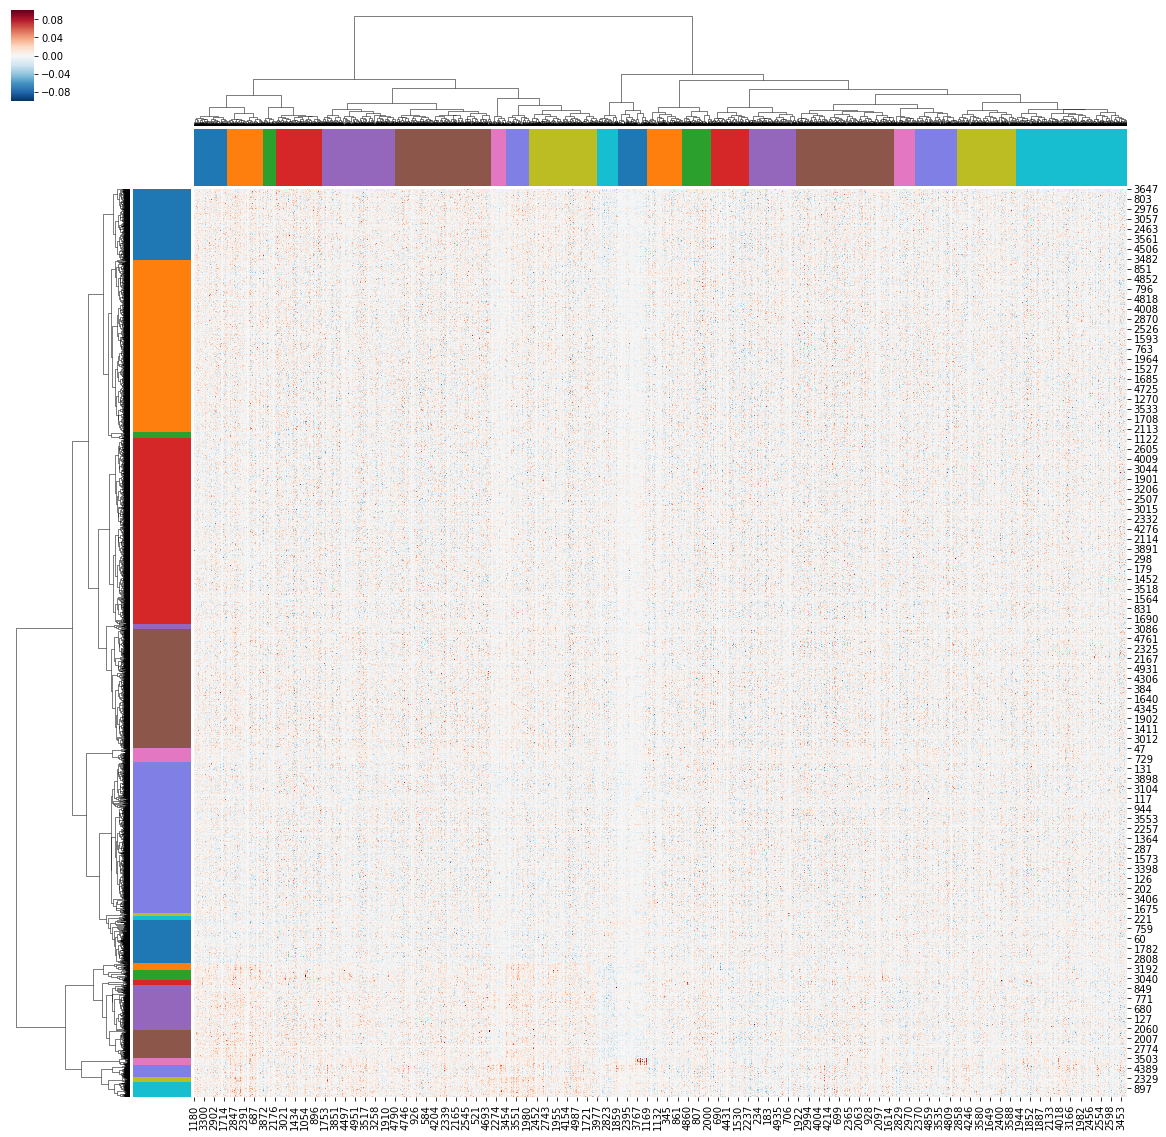

In [95]:
cm = sb.clustermap(G.cpu().numpy(), row_linkage=row_linkage, row_colors=[cm_cycle(c) for c in row_clusters],
        col_linkage=col_linkage, col_colors=[cm_cycle(c) for c in col_clusters],
        figsize=(20, 20),cmap="RdBu_r", vmin=-0.1,vmax=0.1)

In [82]:
# Z = [0,2,4,6,8,10]
Z = [4]
nZ = len(Z)
back_img = []
for z in Z:
    back_img.append(np.power(f.get_tif_rasl_as_vol(z,range(1,200)).mean(axis=2),.4))
    

In [99]:
row_clust_to_plot = [17]
col_clust_to_plot = [10]

multi


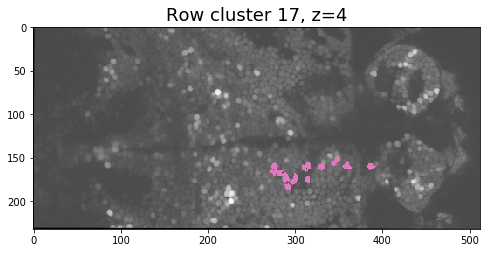

In [97]:
nrows = len(row_clust_to_plot)
nZ = 1
plt.subplots(nrows,nZ, figsize=[8*nZ,4*nrows])
# for c in range(g_nclust):
for ic,clust in enumerate(row_clust_to_plot):
    for iz, z in enumerate(Z):
        #Select rois in raphe in this slices, and get their coordinates.
        coords = df[(row_clusters==clust)].coords
#         poly_coords = df[(row_clusters==clust) & (df.z==z)].poly
#         poly_coords = df[(row_clusters==clust)].poly
#         coords = [np.round(poly[~np.isnan(poly).any(axis=1)])[:,(1,0)].astype(int) for poly in poly_coords]
        plt.subplot(nrows,nZ,ic*nZ+iz+1)
        #Overlay the ROIs on the background image and display:
        # hack iz hardcode
        img = vizutil.overlay_coords(back_img[iz], coords, list(cm_cycle(clust)[:3]), alpha=1)
        plt.imshow(img,interpolation='nearest')
        plt.title("Row cluster {}, z={}".format(clust,z),fontsize=18)

multi


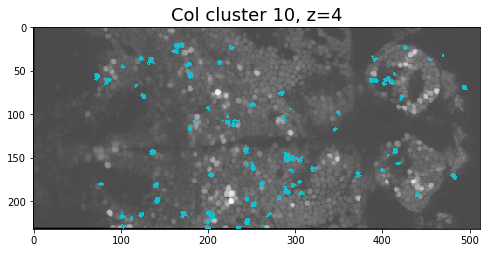

In [100]:
nrows = len(col_clust_to_plot)
plt.subplots(nrows,nZ, figsize=[8*nZ,4*nrows])
# for c in range(g_nclust):
for ic,clust in enumerate(col_clust_to_plot):
    for iz, z in enumerate(Z):
        #Select rois in raphe in this slices, and get their coordinates.
#         coords = df[(g_clusters==clust) & (df.z==z)].coords
#         poly_coords = df[(row_clusters==clust) & (df.z==z)].poly
        coords = df[(col_clusters==clust)].coords
#         poly_coords = df[(col_clusters==clust)].poly
#         coords = [np.round(poly[~np.isnan(poly).any(axis=1)])[:,(1,0)].astype(int) for poly in poly_coords]
        plt.subplot(nrows,nZ,ic*nZ+iz+1)
        #Overlay the ROIs on the background image and display:
        img = vizutil.overlay_coords(back_img[iz], coords, list(cm_cycle(clust)[:3]), alpha=1)
        plt.imshow(img,interpolation='nearest')
        plt.title("Col cluster {}, z={}".format(clust,z),fontsize=18)

In [ ]:
s = 0
e = 440
fig, ax = plt.subplots(1,2, figsize=(5,100))
ax[0].imshow(X[slice(*idx_permute(s,e,exclude_idx))].T)
ax[1].imshow(x_fish[s:e].T)

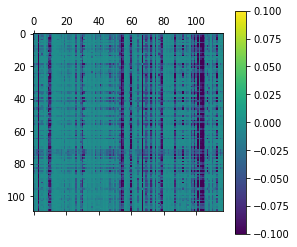

In [127]:
colidx = col_clusters==34
rowidx = row_clusters==7
plt.matshow(G[rowidx][:,colidx],vmin=-0.1,vmax=0.1)
plt.colorbar()

In [ ]:
ind = slice(*idx_permute(2400,2800, exclude_idx))
# ind = slice(*idx_permute(0,400, exclude_idx))

In [6]:
# model = Granger(len(neuron_ids),1,bias=False)
model = Granger(X.shape[1],1,bias=False)
G = model.G.data[0].detach().cpu().numpy()
# trunc_fish = x_fish[0:400]
# trunc_fish = x_fish[440:840]
# trunc_fish = x_fish[840:1240]
# trunc_fish = x_fish[1240:1640]
# trunc_fish = x_fish[1640:2040]
# trunc_fish = x_fish[1640:2440]
# trunc_fish = x_fish[640:840]
# trunc_fish = x_fish[2400:2800]
# trunc_fish = x_fish[2600:2800]
# trunc_fish = x_fish
# data = T.utils.data.TensorDataset(T.from_numpy(X[ind,None,neuron_ids]).cuda(),
#                                   T.from_numpy(Y[ind,neuron_ids]).cuda())
data = T.utils.data.TensorDataset(T.from_numpy(X[ind,None]).cuda(),
                                  T.from_numpy(Y[ind]).cuda())
l1 = 5e-6
# train(model,data,10,l1=l1,batch_size=4) # max(bz)==4 for all neurons
train(model,data,3,l1p=1e-0,lr=1e-1,batch_size=1,verbose=False)
train(model,data,15,l1p=5e-2,lr=1e-3,batch_size=1,verbose=False)
G = model.G.data[0].detach().cpu().numpy()

100%|██████████| 15/15 [09:54<00:00, 39.62s/it]
